## LOAD SOLUTION FILES

In [1]:
import os
import pickle
import pandas as pd
from utils import * 

# folder = "C:\\Users\\le\\Desktop\\Intern\\Predict_PathFlow\\Output\\"
folder = '/Users/viviane/Desktop/Internship/Path_Flow_Prediction/Output/'
all_output = []
for files in os.listdir(folder)[0:5]:
    with open(folder+files, "rb") as file:
        output = pickle.load(file)
        file.close()
        all_output.append(output)
        # all_output = fuse_stats(all_output, output)

# LOAD GRAPH

In [4]:
%run utils.py
X = torch.zeros([5, 3025], dtype=torch.float32)
Y = torch.zeros([5, 1155], dtype=torch.float32)

for i in tqdm(range(5)) :
    file_name = f"Output/5by5_Data{i}"
    x, y = create_datapoint(file_name, 5, 5, 3 )
    X[i] = (x)
    Y[i] = (y)

  0%|          | 0/5 [00:00<?, ?it/s]

In [255]:
from torch.autograd import Variable

def nopeak_mask(size):
    """Tạo mask được sử dụng trong decoder để lúc dự đoán trong quá trình huấn luyện
     mô hình không nhìn thấy được các từ ở tương lai
    """
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    # np_mask = np_mask.to(device)

    return np_mask

def create_masks(src, trg):
    """ Tạo mask cho encoder,
    để mô hình không bỏ qua thông tin của các kí tự PAD do chúng ta thêm vào
    """
    src_mask = (src != 0).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != 0).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask

in_mask, out_mask = create_masks(T_demand, Used_path)
in_mask.shape

torch.Size([1, 25, 1, 25])

In [ ]:
# %run utils.py
%run attention.py

# Load output as tensor
Used_path = getOutputTensor(all_output[0]['path_flow'], OD_demand, Nodes) # shape 1x25x25
mask = torch.rand(1, 1, 25) #need to create function to generate mask, mask for input and output are difference

# Check decoder block
d_output = Decoder(25, 512, 6, 8, 0.1)(Used_path, x2, mask, mask) #torch.Size([1, 25, 512])
d_output = nn.Linear(512, 25)(d_output)
d_output.shape

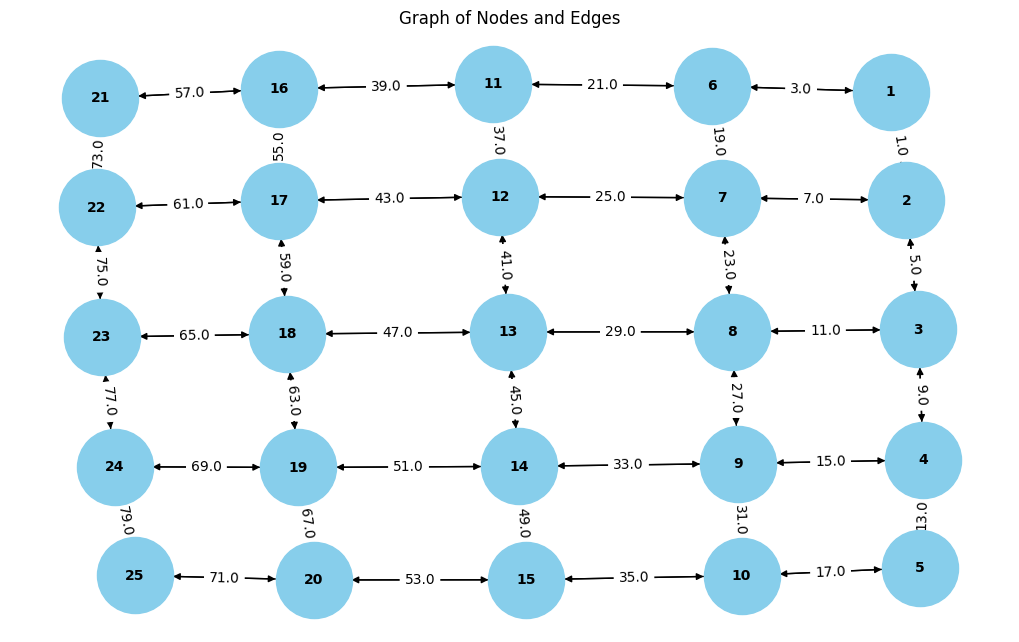

In [61]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.DiGraph()

nodes = pd.DataFrame(all_output[0]["data"]["nodes"], columns=["id"])
# Add nodes to the graph
for _, row in nodes.iterrows():
    G.add_node(row['id'])

# Add edges to the graph
for _, row in network.iterrows():
    src = row['src']
    dst = row['dst']
    link_id = row['link_id']
    capacity = row['capacity']
    length = row['length']
    free_flow_time = row['free_flow_time']
    link_flow = row['link_flow']
    
    G.add_edge(src, dst, link_id=link_id, capacity=capacity, length=length, 
               free_flow_time=free_flow_time, link_flow=link_flow, color='black', direction='forward')

# Visualize the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['link_id']}" for u, v, d in G.edges(data=True)})
plt.title('Graph of Nodes and Edges')
plt.show()


### Test Encoder

In [64]:
%run attention.py
from attention import *

norm_layer = Norm(d_model=512)  # Khởi tạo lớp chuẩn hóa với kích thước d_model là 512
dropout_1 = nn.Dropout(0.1)
dropout_2 = nn.Dropout(0.1)

x = torch.rand(32, 10, 512)  # Một tensor ngẫu nhiên có kích thước (batch_size=32, num_heads = 8, sequence_length=10 (so hang), d_model=512 (dimension))
mask = torch.rand(32, 1, 10) 

output = norm_layer(x) 
output[0].shape

att_out, score = attention(x, x, x)
# att_out.shape # = x.shape

multihead_out = MultiHeadAttention(8, 512)(x, x, x)
multihead_out.shape # = x.shape

x = EncoderLayer(512, 8)(x, mask)
x.shape # = x.shape

# Input của Encoder phải là tensor 3D 
# 6 layer encoder, 8 head attention
input_tensor = torch.rand(5, 10, 3025)
mask_tensor = torch.rand(input_tensor.shape[0], 1, input_tensor.shape[1])
x2 = Encoder(input_dim=3025, d_model=512, N=6, heads=8, dropout=0.1)(input_tensor, mask_tensor)
x2.shape

torch.Size([5, 10, 512])

### Gộp các ma trận khác size thành tensor 3D
Áp dụng để gộp các ma trận link feature, OD matrix, path set matrix thành 1 tensor 3D trước khi đưa vào Encoder

In [61]:
import torch.nn.functional as F

# Khởi tạo các ma trận với kích thước khác nhau
matrix1 = torch.randn(2, 3)  # Kích thước 2x3
matrix2 = torch.randn(3, 4)  # Kích thước 3x4
matrix3 = torch.randn(4, 5)  # Kích thước 4x5

# Tính toán kích thước lớn nhất của các ma trận
max_size = max(matrix1.size(0), matrix2.size(0), matrix3.size(0)), max(matrix1.size(1), matrix2.size(1), matrix3.size(1))

# Thêm padding cho mỗi ma trận để chúng có kích thước giống nhau
matrix1_padded = F.pad(matrix1, (0, max_size[1] - matrix1.size(1), 0, max_size[0] - matrix1.size(0)))
matrix2_padded = F.pad(matrix2, (0, max_size[1] - matrix2.size(1), 0, max_size[0] - matrix2.size(0)))
matrix3_padded = F.pad(matrix3, (0, max_size[1] - matrix3.size(1), 0, max_size[0] - matrix3.size(0)))

# Gộp các ma trận thành một tensor 3D
tensor_3d = torch.stack((matrix1_padded.unsqueeze(0), matrix2_padded.unsqueeze(0), matrix3_padded.unsqueeze(0)), dim=0).squeeze()

# Kiểm tra kích thước của tensor 3D
print(tensor_3d.shape)  # Kết quả sẽ là (3, 4, 5)


torch.Size([3, 4, 5])


### Tính softmax cho 1 tensor đầu vào 

In [136]:

def softmax(x):
    # x = torch.tensor(x)
    """Tính softmax cho một tensor đầu vào x. Softmax được tính cho mỗi hàng của ma trận đầu vào
    Tổng mỗi hàng bằng 1.
    """
    return torch.nn.functional.softmax(x, dim=-1)

a = softmax(T_demand)
print(T_demand[0][0])
a[0][0]

tensor([   0.,    0.,  799.,    0.,    0.,    0.,    0.,    0.,    0., 1844.,
           0.,    0., 1363., 1673.,    0.,    0., 1531.,    0.,  150.,  878.,
           0.,  931.,    0.,  665.,  219.])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [34]:
T_path_flows = getOutputEncoding(5, 5, 3, OD_demand, all_output[0]['path_flow']) # size 1x1155
index = torch.nonzero(T_path_flows) # index la 1 matrix
print([i for i in index])
# print([T_path_flows[0][i] for i in index])

[tensor([0, 3]), tensor([ 0, 23]), tensor([ 0, 29]), tensor([ 0, 32]), tensor([ 0, 38]), tensor([ 0, 44]), tensor([ 0, 47]), tensor([ 0, 50]), tensor([ 0, 56]), tensor([ 0, 59]), tensor([ 0, 66]), tensor([ 0, 73]), tensor([ 0, 77]), tensor([ 0, 81]), tensor([ 0, 89]), tensor([ 0, 92]), tensor([ 0, 93]), tensor([ 0, 98]), tensor([  0, 101]), tensor([  0, 104]), tensor([  0, 105]), tensor([  0, 110]), tensor([  0, 113]), tensor([  0, 120]), tensor([  0, 127]), tensor([  0, 129]), tensor([  0, 137]), tensor([  0, 140]), tensor([  0, 146]), tensor([  0, 152]), tensor([  0, 153]), tensor([  0, 165]), tensor([  0, 170]), tensor([  0, 173]), tensor([  0, 174]), tensor([  0, 177]), tensor([  0, 185]), tensor([  0, 187]), tensor([  0, 189]), tensor([  0, 193]), tensor([  0, 197]), tensor([  0, 206]), tensor([  0, 209]), tensor([  0, 221]), tensor([  0, 224]), tensor([  0, 225]), tensor([  0, 230]), tensor([  0, 246]), tensor([  0, 249]), tensor([  0, 252]), tensor([  0, 256]), tensor([  0, 260]

### Extract OD demand and path set

In [5]:
demand = []
path_links = []
path_flows = []
nodes = []
network = []

for i in tqdm(range(1000)) :
    file_name = f"Output/5by5_Data{i}"
    file = open(file_name, "rb")
    stat = pickle.load(file)
    file.close()
    path_links.append(stat["data"]["paths_link"])
    demand.append(stat["data"]["demand"])
    path_flows.append(stat["path_flow"])
    nodes.append(stat["data"]["nodes"])
    network.append(stat["data"]["network"])

  0%|          | 0/1000 [00:00<?, ?it/s]

Extract graph

In [6]:
def get_graphTensor(network):
    # convert data to numpy
    data = network[['link_id', 'init_node', 'term_node', 'capacity', 'length', 'free_flow_time']].to_numpy()
    # create network tensor 3D
    data = torch.tensor(data).unsqueeze(0)
    return data

Graph = [get_graphTensor(net) for net in network]
Graph[0].shape #torch.Size([1, 80, 6])


torch.Size([1, 80, 6])

Extract OD demand tensor

In [33]:
%run utils.py
%run attention.py

# Tranform a dictionary to a tensor, flatten, transpose, and unsqueeze to get a 3D tensor
def preprocessTensor(OD_dict, nodes):
    T_demand = convert_DictToTensor(OD_dict, nodes)# size (1, 25, 25)
    T_demand = torch.flatten(T_demand, start_dim=1) # shape 1x625
    T_demand = torch.transpose(T_demand, 0, 1) # shape 625x1
    T_demand = T_demand.unsqueeze(0) # shape 1x625x1
    return T_demand

OD_demands = [preprocessTensor(d, n) for d, n in zip(demand, nodes)] # 1 feature of X, a list of OD demand tensor
len(OD_demands)
OD_demands[0].shape
# # Check encoder block
# mask_tensor = torch.rand(T_demand.shape[0], 1, T_demand.shape[-2]) #shape 1 x 1 x 625
# x2 = Encoder(input_dim=T_demand.shape[-1], d_model=512, N=6, heads=8, dropout=0.1)(T_demand, mask_tensor)
# x2.shape

torch.Size([1, 625, 1])

Extract all feasible paths (path ID) of each OD demand matrix

In [46]:
# Create dictionary of all unique paths
def path_encoding(data):
    unique_values_set = set()
    all_path_link = [data[i].values() for i in range (len(data))]
    for path_set in all_path_link:
        for path in path_set:
            for p in path:
                unique_values_set.add(tuple(p))
    path_set_dict = {v: k for k, v in enumerate(unique_values_set, start=1)}
    return path_set_dict

def extract_3paths(data, encode_dict):
    new_path_links = [{k: [tuple(path) for path in v] for k, v in path_sets.items()} for path_sets in data]
    
    # Encode paths
    for path_set in new_path_links:
        for k, v in path_set.items():
            path_set[k] = [encode_dict[path] for path in v]
    
    path1, path2, path3 = [], [], []
    for path_set in new_path_links:
        p1, p2, p3 = {}, {}, {}
        for k, v in path_set.items():
            p1[k], p2[k], p3[k] = v
        path1.append(p1); path2.append(p2); path3.append(p3)    
    return path1, path2, path3

def preprocess_path(path_links, nodes):
    # path_encode_dict = path_encoding(path_links)
    path1, path2, path3 = extract_3paths(path_links, path_encoding(path_links))

    # extract 3 path tensors
    Path1_tensor = [preprocessTensor(path, node) for path, node in zip(path1, nodes)]
    Path2_tensor = [preprocessTensor(path, node) for path, node in zip(path2, nodes)]
    Path3_tensor = [preprocessTensor(path, node) for path, node in zip(path3, nodes)]
    stack = [torch.stack([p1, p2, p3], dim=1).squeeze(0) for p1, p2, p3 in zip(Path1_tensor, Path2_tensor, Path3_tensor)]
    return stack

Path_tensor = preprocess_path(path_links, nodes)
Path_tensor[0].shape

torch.Size([3, 625, 1])

Extract flow on each feasible path

In [47]:
def OD_flow_mapping(demand, path_flows):
    # Map OD pair with flows
    all_path_flow = []
    for d, flows in zip(demand, path_flows):
        flow ={}
        for k, v in zip(d.keys(), flows):
            flow[k] = v
        all_path_flow.append(flow)
    return all_path_flow

def extract_3flows(path_flow_dict):
    flow1, flow2, flow3 = [], [], []
    for path_set in path_flow_dict:
        f1, f2, f3 = {}, {}, {}
        for k, v in path_set.items():
            f1[k], f2[k], f3[k] = v
        flow1.append(f1); flow2.append(f2); flow3.append(f3)    
    return flow1, flow2, flow3

def preprocess_flow(demand, path_flows, nodes):
    flow1, flow2, flow3 = extract_3flows(OD_flow_mapping(demand, path_flows))

    # extract 3 flow tensors
    Flow1_tensor = [preprocessTensor(flow, node) for flow, node in zip(flow1, nodes)]
    Flow2_tensor = [preprocessTensor(flow, node) for flow, node in zip(flow2, nodes)]
    Flow3_tensor = [preprocessTensor(flow, node) for flow, node in zip(flow3, nodes)]
    stack = [torch.stack([f1, f2, f3], dim=1).squeeze(0) for f1, f2, f3 in zip(Flow1_tensor, Flow2_tensor, Flow3_tensor)]
    return stack

Flow_tensor = preprocess_flow(demand, path_flows, nodes)
Flow_tensor[0].shape


torch.Size([3, 625, 1])

In [110]:
"""
Each file includes: dict_keys(['data', 'path_flow', 'link_flow', 'model_status', 'solving_time'])

Read 1st file's data:
data = {'network' :Network, 'demand' :OD_mat, 'nodes':Nodes,'links':links,'orig':O,'dest':D,'fftt':fft,'capacity':cap, 'length': lengths, 'beta':beta,
        'approx':segments,'eta':eta,'paths_link':paths, 'paths_node':paths_N, 'delta':delta,'alpha':alpha, 'Adjacency_matrix' : Adj}
data's dict_keys(['network', 'demand', 'nodes', 'links', 'orig', 'dest', 'fftt', 'capacity', 'length', 'beta', 'approx', 'eta', 'paths_link', 'paths_node', 'delta', 'alpha', 'Adjacency_matrix'])

len(data["demand"]) = 372 
len("path_flow") = 372
len("link_flow") = 80
len(path_nodes) = 372
          """

# Get demand & O-D
od_pairs = []
# demand = []
all_path_links = []
path_flow = []
# all_nodes = []

for i in range (len(all_output)):
    od_demands = all_output[i]["data"]["demand"] # type dictionary
    path_links = all_output[i]["data"]["paths_link"] # type dictionary
    path_flow.extend(all_output[i]["path_flow"]) #type list
    path_nodes = all_output[i]["data"]["paths_node"] # type dictionary
    od_pairs.extend(list(od_demands.keys()))
    all_path_links.extend(path_links.values())

origins = [od[0] for od in od_pairs]
destinations = [od[1] for od in od_pairs]

# Get path links
path1 = [tuple(paths[0]) for paths in all_path_links]
path2 = [tuple(paths[1]) for paths in all_path_links]
path3 = [tuple(paths[2]) for paths in all_path_links]

# Get path flow
flow1 = [flows[0] for flows in path_flow]
flow2 = [flows[1] for flows in path_flow]
flow3 = [flows[2] for flows in path_flow]

df = pd.DataFrame({
    'origin': origins,
    'destination': destinations,
    # 'demand': demand,
    'path1': path1,
    'path2': path2,
    'path3': path3,
    'flow1': flow1,
    'flow2': flow2,
    'flow3': flow3,
})

df['p1'] = df['path1'].map(path_set_dict.get)
df['p2'] = df['path2'].map(path_set_dict.get)
df['p3'] = df['path3'].map(path_set_dict.get)
df = df.drop(['path1', 'path2', 'path3'], axis=1)

df.head()

,origin,destination,flow1,flow2,flow3,p1,p2,p3
0,18,19,828.0,0.0,0.0,452,1140,758
1,3,7,0.0,1614.0,0.0,455,770,210
2,17,25,0.0,0.0,760.0,429,883,757
3,21,9,0.0,0.0,95.0,676,900,1009
4,13,19,0.0,973.0,0.0,532,842,884


In [4]:
def concatenate_lists(row, path_col, nodes_col, flow_col):
    return [row[path_col], row[nodes_col], row[flow_col]]

# Combine all information
df['p1'] = df.apply(concatenate_lists, args=('path1', 'nodes1', 'flow1'), axis=1)
df['p2'] = df.apply(concatenate_lists, args=('path2', 'nodes2', 'flow2'), axis=1)
df['p3'] = df.apply(concatenate_lists, args=('path3', 'nodes3', 'flow3'), axis=1)

def find_path(row):
    if row['p1'][2]!=0:
        return row['p1']
    if row['p2'][2]!=0:
        return row['p2']
    if row['p3'][2]!=0:
        return row['p3']

# Find the path that has flow
df['path_node_flow'] = df.apply(find_path, axis=1)

def extract_info(row):
    path = row['path_node_flow'][0]
    node = row['path_node_flow'][1]
    flow = row['path_node_flow'][2]
    return path, node, flow

# Extract information
df[['path', 'node', 'flow']] = df.apply(extract_info, axis=1, result_type='expand')
df = df[['origin', 'destination', 'demand', 'path', 'node', 'flow']]
df.head()

,origin,destination,demand,path,node,flow
0,9,15,1381,"[32, 48]","[9, 14, 15]",1381.0
1,24,8,1175,"[69, 63, 47, 29]","[24, 19, 18, 13, 8]",1175.0
2,12,15,2000,"[40, 44, 48]","[12, 13, 14, 15]",2000.0
3,4,20,495,"[14, 32, 48, 52]","[4, 9, 14, 15, 20]",495.0
4,4,12,652,"[9, 10, 23, 24]","[4, 3, 8, 7, 12]",652.0
